<a href="https://colab.research.google.com/github/jmar008/AI4Devs-lab-google-colab/blob/main/Lab_LLM_RAG_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construyendo un Chatbot LLM de Código Abierto en Local con RAG

## 1. Introducción

Los _Large Language Models_ (LLMs), destacan por su habilidad para condensar ingentes cantidades de conocimiento sobre el mundo en en "unos pocos" miles de millones de parámetros. Sin embargo, **los LLMs tienen dos limitaciones importantes**:
1. Su conocimiento sólo llega hasta el momento de la fecha de corte del conjunto de datos con el que han sido entrenados.
2. A veces tienden a inventarse cosas (alucinaciones) cuando se les hacen preguntas sobre conceptos específicos.

**Utilizando** la técnica _Retrieval-Augmented Generation_ **(RAG), conseguimos que los LLMs tengan acceso a información muy específica** como contexto adicional para responder a nuestras preguntas, **tan actualizada como seamos capaces de proporcionársela.**

### Retrieval-Augmented Generation (RAG)

El término "Generación Aumentada por Recuperación" (RAG) procede del estudio _Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks_, publicado en 2020 por investigadores de Facebook AI Research.

El fundamento del RAG es el siguiente:

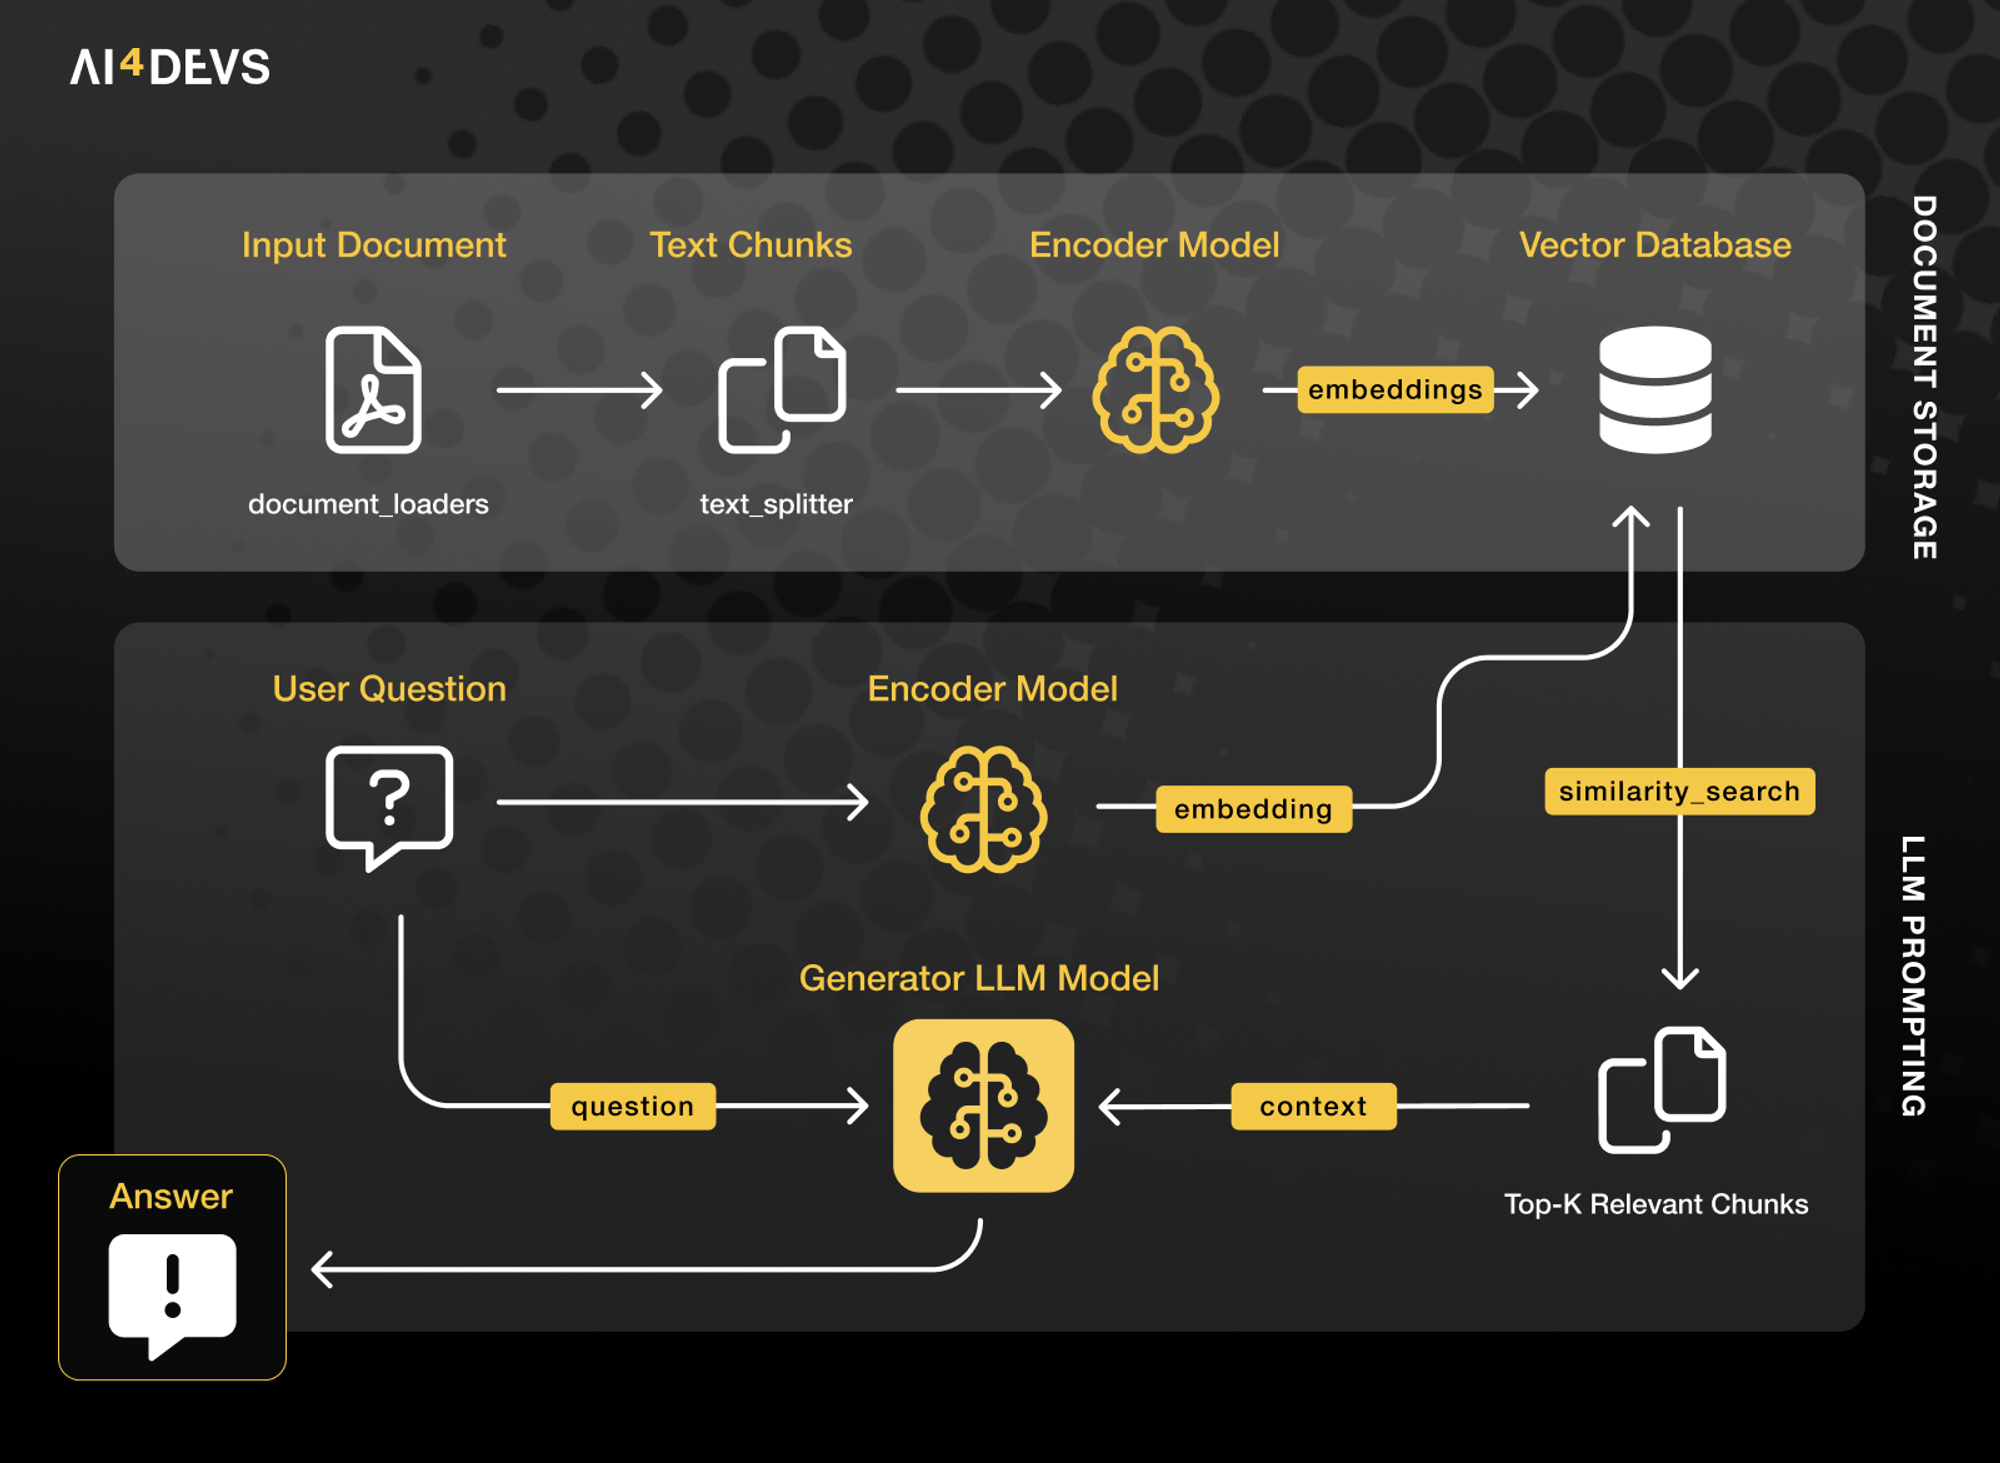

1. Partimos de una base de conocimientos, como un conjunto de documentos de texto, que transformamos en representaciones vectoriales densas (también denominadas embeddings) mediante un modelo codificador.

2. Cuando recibimos una pregunta del usuario, también la convertimos en un vector de embedding utilizando el mismo modelo codificador. A continuación, buscamos vectores similares entre todos los disponibles empleando una métrica de similitud. El proceso de codificar la pregunta y localizar documentos similares en la base de conocimientos constituye el componente recuperador.

3. Con la pregunta y el contexto adicional de los documentos recuperados, alimentamos un LLM que actúa como componente generador para obtener la respuesta.

De esta forma, superamos la restricción temporal del conocimiento; permitiendo actualizar la base de datos con información reciente y reducimos significativamente las alucinaciones al proporcionar al modelo información específica y contextual para responder a las preguntas.

## 2. Configuración

Comencemos conectándonos a una GPU T4 y a continuación instalando las bibliotecas necesarias.

Explicación de las bibliotecas instaladas:

- `torch`: PyTorch, biblioteca de aprendizaje profundo
- `transformers`: Hugging Face Transformers, para trabajar con modelos de lenguaje
- `bitsandbytes`: Para cuantización de modelos
- `accelerate`: Para optimizar el rendimiento en GPUs
- `langchain` y `langchain-community`: Para construir aplicaciones con LLMs
- `sentence-transformers`: Para generar embeddings de texto
- `pypdf`: Para trabajar con archivos PDF
- `faiss-cpu`: Para búsqueda de similitud eficiente
- `streamlit`: Para crear interfaces de usuario web

In [ ]:
!pip install torch transformers bitsandbytes accelerate langchain langchain-community sentence-transformers pypdf faiss-cpu streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.74
    Uninstalling langchain-core-0.

Creamos una cuenta de Hugging Face y aceptamos los términos y condiciones del modelo Gemma: https://huggingface.co/google/gemma-2-2b-it

Nos creamos un token de tipo lectura en esta página: https://huggingface.co/settings/tokens y lo guardamos como nuevo secreto (icono de la llave) con el nombre HF_TOKEN

Comprobamos que nos hemos conectado correctamente a la GPU de Google Colab

In [ ]:
import torch
print(torch.cuda.is_available())

True


## 3. Carga del modelo LLM

En este proyecto, utilizaremos el modelo Gemma 2B Instruct de Google. Gemma es un modelo de lenguaje de código abierto que ofrece un buen equilibrio entre rendimiento y eficiencia.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = 'google/gemma-2-2b-it'
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='cuda',
                                             quantization_config=quantization_config)

model.eval()

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_

Explicación:

- Utilizamos la biblioteca `transformers` para cargar el modelo y el tokenizador.
- Aplicamos cuantización de 4 bits para reducir el uso de memoria y acelerar la inferencia.
- Movemos el modelo a la GPU (`device_map='cuda'`) para un procesamiento más rápido.
- Ponemos el modelo en modo de evaluación (`model.eval()`) para desactivar el dropout y otras capas de entrenamiento.

Testeamos nuestro modelo

In [ ]:
input_text = 'Dame un código sencillo de un algoritmo de fibonacci'
input_ids = tokenizer(input_text, return_tensors='pt').to('cuda')

outputs = model.generate(**input_ids, max_new_tokens=500)
print(tokenizer.decode(outputs[0]))

<bos>Dame un código sencillo de un algoritmo de fibonacci.

```
function fibonacci(n)
  if n <= 0
    return 0
  elif n == 1
    return 1
  else
    return fibonacci(n-1) + fibonacci(n-2)
end
```

**Explicación:**

Este código implementa un algoritmo de Fibonacci recursivo. 

* **`function fibonacci(n)`:** Define una función llamada "fibonacci" que toma un entero "n" como argumento.
* **`if n <= 0`:** Si "n" es menor o igual a 0, devuelve 0.
* **`elif n == 1`:** Si "n" es igual a 1, devuelve 1.
* **`else`:** Si "n" es mayor que 1, calcula el valor de la secuencia de Fibonacci sumando los valores de las dos funciones anteriores.

**Ejemplo de uso:**

```
print(fibonacci(5))  # Salida: 5
```

**Puntos a considerar:**

* Este algoritmo es recursivo, lo que significa que llama a la misma función para calcular el valor de la secuencia de Fibonacci.
* Este algoritmo es simple y fácil de entender, pero puede ser ineficiente para valores grandes de "n" debido a la recursión.


**Alternativas:*

## 4. Componente generador (Modelo LLM)

Ahora implementaremos la función principal para generar respuestas utilizando nuestro modelo LLM con la pregunta y el contexto.

In [ ]:
def generate(question: str, context: str):
    if context == None or context == "":
        prompt = f"Da una respuesta detallada a la siguiente pregunta. Pregunta: {question}"
    else:
        prompt = f"""Utilizando la información contenida en el contexto, da una respuesta detallada a la pregunta.
        Contexto: {context}.
        Pregunta: {question}"""
    chat = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        chat,
        tokenize=False,
        add_generation_prompt=True,
    )
    inputs = tokenizer.encode(
        formatted_prompt, add_special_tokens=False, return_tensors="pt"
    ).to('cuda')
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=500,
            do_sample=False,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    response = response[len(formatted_prompt):]  # eliminar el prompt de entrada de la respuesta
    response = response.replace("<end_of_turn>", "")  # eliminar el token eos
    return response

Explicación:

- La función `generate` toma una pregunta y un contexto opcional como entrada.
- Si no se proporciona contexto, se utiliza un prompt simple. Si hay contexto, se incluye en el prompt.
- Utilizamos el formato de chat del modelo para estructurar la entrada.
- Generamos la respuesta utilizando el método `generate` del modelo.
- Procesamos la salida para eliminar tokens especiales y el prompt de entrada.

Probamos la función con una consulta de ejemplo

In [ ]:
print(generate(question="Hola!", context=""))

¡Hola! 👋 

¿Qué puedo hacer por ti hoy? 😊 

Para poder ayudarte mejor, necesito que me digas qué necesitas. ¿Quieres que te cuente una historia? ¿Necesitas información sobre algún tema? ¿O simplemente quieres charlar un rato? 

Cuéntame qué tienes en mente y haré todo lo posible para ayudarte. 😉 



## 5. Componente Recuperador: Modelo Codificador + Búsqueda de Similitud

Para implementar RAG, necesitamos un componente que pueda codificar texto en vectores densos y, realizar búsquedas de similitud eficientes.
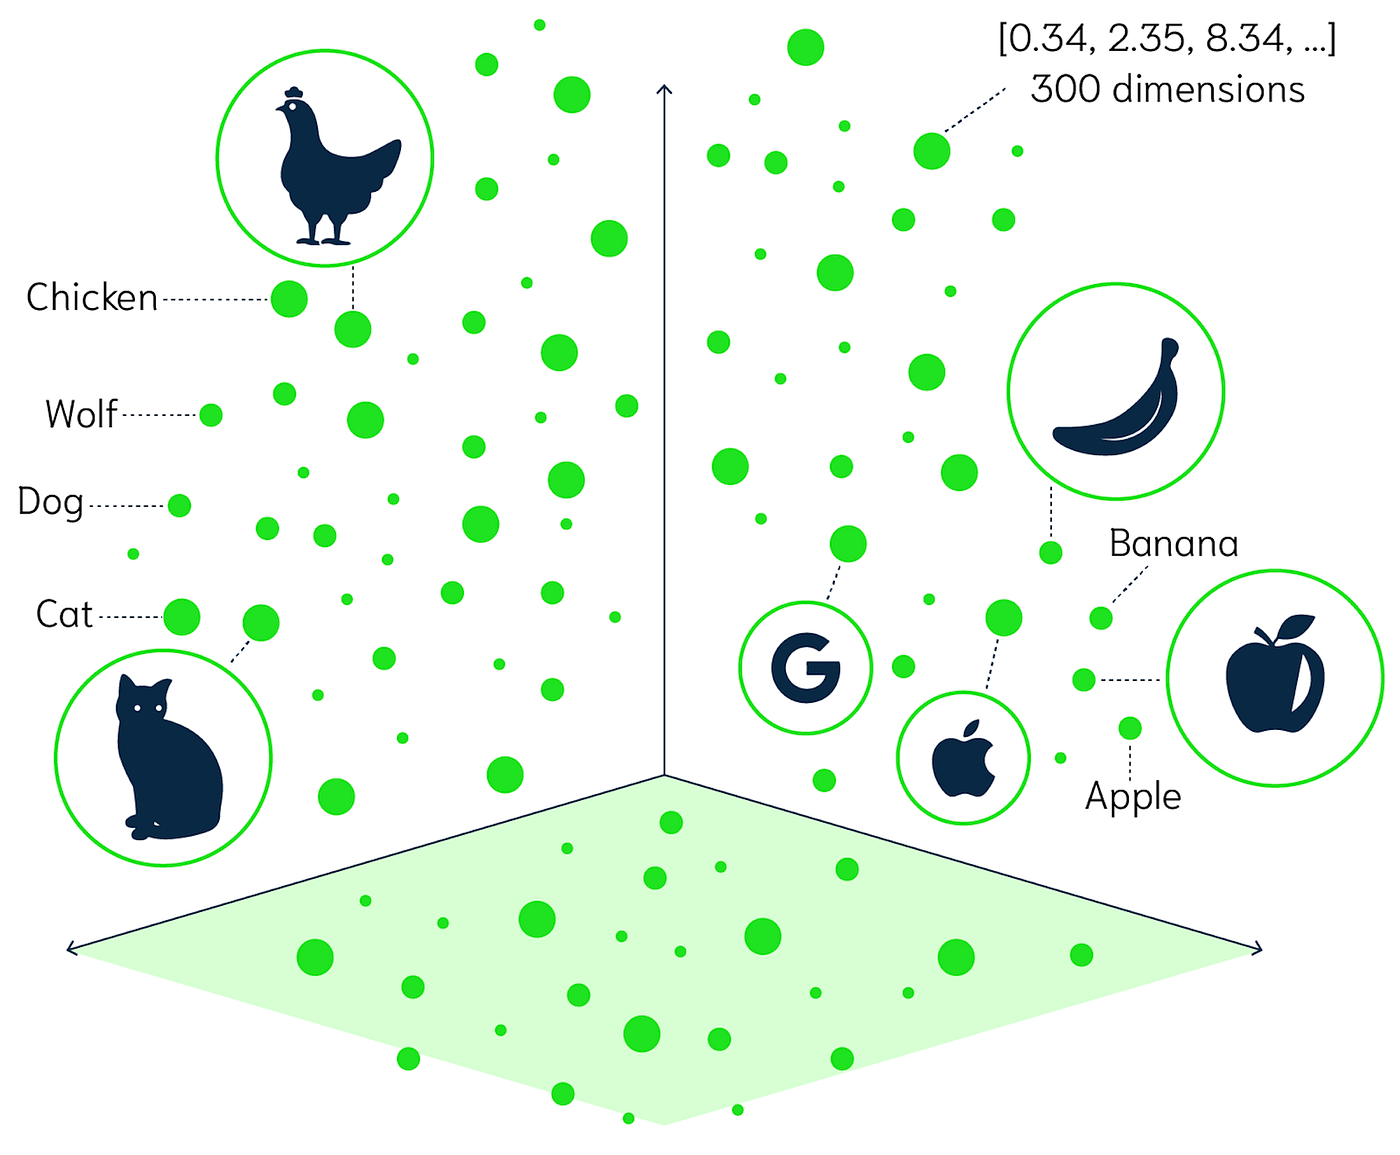

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings

encoder = HuggingFaceEmbeddings(
    model_name='sentence-transformers/all-MiniLM-L12-v2',
    model_kwargs={'device': "cpu"}
)

/tmp/ipython-input-1592489452.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  encoder = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Explicación:

- Utilizamos el modelo `all-MiniLM-L12-v2` de Sentence Transformers para generar embeddings.
- Este modelo ofrece un buen equilibrio entre calidad y eficiencia para la generación de embeddings.

Lo probamos con una consulta de ejemplo

In [ ]:
embeddings = encoder.embed_query("El ratón gris.")
print(embeddings)
print(len(embeddings))

[-0.11285913735628128, 0.04508903622627258, 0.004427876323461533, 0.04593704268336296, -0.0199542585760355, -0.023533552885055542, 0.06444794684648514, 0.030865980312228203, 0.05865147337317467, -0.035564251244068146, 0.03867712616920471, 0.04344853013753891, -0.10867499560117722, 0.017557291314005852, -0.12679851055145264, -0.13429641723632812, 0.05465080216526985, -0.0018640501657500863, 0.03906833007931709, -0.03315163031220436, 0.048124220222234726, -0.009512903168797493, -0.032711248844861984, 0.16016381978988647, -0.06320548802614212, -0.03835320100188255, -0.003724187146872282, 0.011551231145858765, -0.05962780490517616, -0.041760124266147614, -0.005654762499034405, -0.01668926328420639, -0.022313285619020462, -0.0614839643239975, -0.017851021140813828, 0.004141986835747957, 0.06419772654771805, -0.05957925692200661, 0.032946713268756866, 0.022820524871349335, 0.031622957438230515, 0.04763513058423996, -0.01457057986408472, 0.04344220086932182, 0.004563747905194759, -0.057813603

Para entenderlo mejor, vamos a probar con un pequeño ejemplo usando la métrica de similitud del coseno
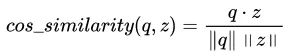

In [ ]:
import numpy as np

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Ejemplo
q = encoder.embed_query("¿Qué es una manzana?")
z1 = encoder.embed_query("Una manzana es una fruta redonda y comestible producida por un manzano.")
z2 = encoder.embed_query("El gato es la única especie domesticada en la familia Felidae.")

print(cosine_similarity(q, z1))
print(cosine_similarity(q, z2))

0.708470772970025
0.39786524570187287


En este ejemplo, veremos que la similitud entre la pregunta y la frase sobre manzanas es mayor que con la frase sobre gatos.

## 6. Carga de Documentos y segmentación

Para crear nuestra base de conocimientos, necesitamos cargar documentos y dividirlos en fragmentos manejables.

In [ ]:
from google.colab import files
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Subir archivos
uploaded = files.upload()

# Procesar archivos subidos
loaders = []
for filename in uploaded.keys():
    # Cargar el archivo PDF
    loaders.append(PyPDFLoader(filename))

pages = []
for loader in loaders:
    pages.extend(loader.load())

# Dividir texto en fragmentos
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer=AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2"),
    chunk_size=256,
    chunk_overlap=32,
    strip_whitespace=True
)

docs = text_splitter.split_documents(pages)

Saving Python para todos.pdf to Python para todos.pdf


Explicación:

- Utilizamos `PyPDFLoader` para cargar archivos PDF.
- El `RecursiveCharacterTextSplitter` divide el texto en fragmentos de tamaño manejable.
- `chunk_size` determina el tamaño máximo de cada fragmento.
- `chunk_overlap` permite que haya cierta superposición entre fragmentos para mantener el contexto.

Para entender mejor el funcionamiento de los parámetros del tamaño de los chunks y el overlap entre ellos, realizaremos un par de ejemplos

In [ ]:
text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit."

def text_splitter_test(chunk_size, chunk_overlap):
  return RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
          tokenizer=AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2"),
          chunk_size=chunk_size,
          chunk_overlap=chunk_overlap,
          strip_whitespace=True
      )

print(text_splitter_test(1,0).split_text(text))
print(text_splitter_test(10,0).split_text(text))
print(text_splitter_test(50,0).split_text(text))
print(text_splitter_test(20,10).split_text(text))

['L', 'o', 'r', 'e', 'm', 'i', 'p', 's', 'u', 'm', 'd', 'o', 'l', 'o', 'r', 's', 'i', 't', 'a', 'm', 'e', 't', ',', 'c', 'o', 'n', 's', 'e', 'c', 't', 'e', 't', 'u', 'r', 'a', 'd', 'i', 'p', 'i', 's', 'c', 'i', 'n', 'g', 'e', 'l', 'i', 't', '.']
['Lorem ipsum dolor sit amet,', 'consectetur adipiscing', 'elit.']
['Lorem ipsum dolor sit amet, consectetur adipiscing elit.']
['Lorem ipsum dolor sit amet, consectetur adipiscing', 'consectetur adipiscing elit.']


In [ ]:
def visualize_chunks(text, chunk_size, chunk_overlap):
    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
    splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer=tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        strip_whitespace=True
    )

    chunks = splitter.split_text(text)

    print(f"Texto original ({len(text)} caracteres):")
    print(text)
    print("\nChunks generados:")
    for i, chunk in enumerate(chunks):
        print(f"\nChunk {i+1} ({len(chunk)} caracteres):")
        print(chunk)
        print("-" * 50)

    print(f"\nNúmero total de chunks: {len(chunks)}")
    print(f"Tamaño promedio de chunk: {sum(len(c) for c in chunks) / len(chunks):.2f} caracteres")

# Texto de ejemplo
text = """
Lorem Ipsum es simplemente el texto de relleno de las imprentas y archivos de texto. Lorem Ipsum ha sido el texto de relleno estándar de las industrias desde el año 1500, cuando un impresor (N. del T. persona que se dedica a la imprenta) desconocido usó una galería de textos y los mezcló de tal manera que logró hacer un libro de textos especimen. No sólo sobrevivió 500 años, sino que tambien ingresó como texto de relleno en documentos electrónicos, quedando esencialmente igual al original. Fue popularizado en los 60s con la creación de las hojas "Letraset", las cuales contenian pasajes de Lorem Ipsum, y más recientemente con software de autoedición, como por ejemplo Aldus PageMaker, el cual incluye versiones de Lorem Ipsum. Es un hecho establecido hace demasiado tiempo que un lector se distraerá con el contenido del texto de un sitio mientras que mira su diseño. El punto de usar Lorem Ipsum es que tiene una distribución más o menos normal de las letras, al contrario de usar textos como por ejemplo "Contenido aquí, contenido aquí". Estos textos hacen parecerlo un español que se puede leer. Muchos paquetes de autoedición y editores de páginas web usan el Lorem Ipsum como su texto por defecto, y al hacer una búsqueda de "Lorem Ipsum" va a dar por resultado muchos sitios web que usan este texto si se encuentran en estado de desarrollo. Muchas versiones han evolucionado a través de los años, algunas veces por accidente, otras veces a propósito (por ejemplo insertándole humor y cosas por el estilo).
"""

print("Ejemplo 1: Chunks pequeños con poco overlap")
visualize_chunks(text, chunk_size=100, chunk_overlap=10)

print("\n" + "=" * 80 + "\n")

print("Ejemplo 2: Chunks más grandes con mayor overlap")
visualize_chunks(text, chunk_size=200, chunk_overlap=50)

print("\n" + "=" * 80 + "\n")

print("Ejemplo 3: Chunks muy grandes con overlap significativo")
visualize_chunks(text, chunk_size=300, chunk_overlap=100)


Ejemplo 1: Chunks pequeños con poco overlap
Texto original (1520 caracteres):

Lorem Ipsum es simplemente el texto de relleno de las imprentas y archivos de texto. Lorem Ipsum ha sido el texto de relleno estándar de las industrias desde el año 1500, cuando un impresor (N. del T. persona que se dedica a la imprenta) desconocido usó una galería de textos y los mezcló de tal manera que logró hacer un libro de textos especimen. No sólo sobrevivió 500 años, sino que tambien ingresó como texto de relleno en documentos electrónicos, quedando esencialmente igual al original. Fue popularizado en los 60s con la creación de las hojas "Letraset", las cuales contenian pasajes de Lorem Ipsum, y más recientemente con software de autoedición, como por ejemplo Aldus PageMaker, el cual incluye versiones de Lorem Ipsum. Es un hecho establecido hace demasiado tiempo que un lector se distraerá con el contenido del texto de un sitio mientras que mira su diseño. El punto de usar Lorem Ipsum es que tiene una 

Para entender mejor cómo funciona la segmentación, podemos visualizar algunos chunks:

In [ ]:
print("Número total de chunks:", len(docs))
print("\nPrimeros 3 chunks:")
for i, doc in enumerate(docs[:3]):
    print(f"\nChunk {i+1}:")
    print(doc.page_content)
    print("-" * 50)

Número total de chunks: 379

Primeros 3 chunks:

Chunk 1:
Python
PARA TODOS
Raúl González Duque
--------------------------------------------------

Chunk 2:
Python
PARA TODOS
Raúl González Duque
--------------------------------------------------

Chunk 3:
Python para todos
por Raúl González Duque
Este libro se distribuye bajo una licencia Creative Commons Reconocimien-
to 2.5 España. Usted es libre de:
copiar, distribuir y comunicar públicamente la obra
hacer obras derivadas
Bajo las condiciones siguientes:
Reconocimiento. Debe reconocer y dar crédito al autor original  
(Raúl González Duque)
Puede descargar la versión más reciente de este libro gratuitamente en la web 
http://mundogeek.net/tutorial-python/
La imágen de portada es una fotografía de una pitón verde de la especie 
Morelia viridis cuyo autor es Ian Chien. La fotografía está licenciada bajo 
Creative Commons Attribution ShareAlike 2.0
--------------------------------------------------


## 7. Base de Datos Vectorial

Ahora añadiremos a la estructura la base de datos vectorial donde guardaremos los chunks y sus correspondientes embeddings generados por el modelo codificador. Para ellos usaremos Faiss, una BD vectorial desarrollada por Meta AI research que tiene un alto rendimiento y eficiencia en búsquedas de similitud entre vectores densos. Para el cálculo de la similitud configuraremos la BD para usar la del coseno que hemos visto anteriormente.

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

faiss_db = FAISS.from_documents(
    docs, encoder, distance_strategy=DistanceStrategy.COSINE
)

Realizamos una pequeña prueba de búsqueda en nuestros documentos con una pregunta relacionada para encontrar los 3 chunks más relevantes.

In [ ]:
query = "¿Cómo creo sockets en python?"
retrieved_docs = faiss_db.similarity_search(query, k=5)

print(f"Resultados para la consulta: '{query}'\n")
for i, doc in enumerate(retrieved_docs):
    print(f"Documento {i+1}:")
    print(doc.page_content)
    print("-" * 50)

Resultados para la consulta: '¿Cómo creo sockets en python?'

Documento 1:
92
soCkets
La comunicación entre distintas entidades en una red se basa en 
Python en el clásico concepto de sockets. Los sockets son un concepto 
abstracto con el que se designa al punto final de una conexión.
Los programas utilizan sockets para comunicarse con otros programas, 
que pueden estar situados en computadoras distintas.
Un socket queda definido por la dirección IP de la máquina, el puerto 
en el que escucha, y el protocolo que utiliza.
Los tipos y funciones necesarios para trabajar con sockets se encuen-
tran en Python en el módulo socket, como no podría ser de otra 
forma.
Los sockets se clasifican en sockets de flujo (socket.SOCK_STREAM) o 
sockets de datagramas (socket.SOCK_DGRAM) dependiendo de si el ser-
vicio utiliza TCP , que es orientado a conexión y fiable, o UDP , respec-
--------------------------------------------------
Documento 2:
Python para todos
94
Una vez que hemos terminado de trab

## 8. Implementación del Chatbot RAG

Ahora combinaremos todos los componentes para crear nuestro chatbot RAG.

In [ ]:
def rag_chatbot(query: str, k: int = 3):
    # Recuperar documentos relevantes
    context = faiss_db.similarity_search(query, k=k)
    context_text = "\n".join([doc.page_content for doc in context])

    # Generar respuesta
    response = generate(query, context_text)

    return response

# Ejemplo de uso
query = "¿Cómo creo sockets en python?"
response = rag_chatbot(query)
print(f"Pregunta: {query}\n")
print(f"Respuesta: {response}")

Pregunta: ¿Cómo creo sockets en python?

Respuesta: El contexto proporcionado describe cómo crear sockets en Python. Aquí te explico cómo hacerlo:

**1. Crear un socket:**

   -  `socket_c = socket.socket()` 
     - Este comando crea un nuevo socket. 

**2. Conectar al servidor:**

   - `socket_c.connect((“localhost”, 9999))`
     - Este comando establece una conexión al servidor. 
     - `("localhost", 9999)`: Define la dirección del servidor y el puerto. 
     -  `localhost` es el nombre del host local, que es el mismo que el que se ejecuta el programa. 
     -  `9999` es el puerto del servidor.

**3. Enviar datos:**

   - `socket_c.send("hola")`
     - Este comando envía el mensaje "hola" al servidor.

**4. Ejemplo completo:**

   - El ejemplo completo muestra cómo crear un cliente y enviar un mensaje al servidor. 

**Puntos clave:**

- **`socket.socket()`:** Crea un nuevo socket.
- **`connect()`:** Conecta al servidor.
- **`send()`:** Envía datos al servidor.
- **`listen()`:** Perm

## 9. Interfaz de streamlit

Escribimos en un archivo la aplicación completa

In [ ]:
%%writefile app.py

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import numpy as np
import streamlit as st
from google.colab import files

class ChatModel:
    def __init__(self, model_id: str = 'google/gemma-2-2b-it', device='cuda'):

        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16
        )

        self.model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            quantization_config=quantization_config
        )
        self.model.eval()
        self.chat = []
        self.device = device

    def generate(self, question: str, context: str = None, max_new_tokens: int = 250):

        if context == None or context == "":
            prompt = f"""Give a detailed answer to the following question. Question: {question}"""
        else:
            prompt = f"""Using the information contained in the context, give a detailed answer to the question.
Context: {context}.
Question: {question}"""

        chat = [{"role": "user", "content": prompt}]
        formatted_prompt = self.tokenizer.apply_chat_template(
            chat,
            tokenize=False,
            add_generation_prompt=True,
        )
        print(formatted_prompt)
        inputs = self.tokenizer.encode(
            formatted_prompt, add_special_tokens=False, return_tensors="pt"
        ).to(self.device)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
            )
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=False)
        response = response[len(formatted_prompt) :]  # remove input prompt from reponse
        response = response.replace("<end_of_turn>", "")  # remove eos token

        return response


class Encoder:
    def __init__(
        self, model_name: str = "sentence-transformers/all-MiniLM-L12-v2", device="cpu"
    ):
        self.embedding_function = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs={"device": device},
        )

class FaissDb:
    def __init__(self, docs, embedding_function):
        self.db = FAISS.from_documents(
            docs, embedding_function, distance_strategy=DistanceStrategy.COSINE
        )

    def similarity_search(self, question: str, k: int = 3):
        retrieved_docs = self.db.similarity_search(question, k=k)
        context = "".join(doc.page_content + "\n" for doc in retrieved_docs)
        return context

def load_and_split_pdfs(file_paths: list, chunk_size: int = 256):
    loaders = [PyPDFLoader(file_path) for file_path in file_paths]
    pages = []
    for loader in loaders:
        pages.extend(loader.load())

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer=AutoTokenizer.from_pretrained(
            "sentence-transformers/all-MiniLM-L12-v2"
        ),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        strip_whitespace=True,
    )
    docs = text_splitter.split_documents(pages)
    return docs

st.title("LLM Chatbot RAG Assistant")


@st.cache_resource
def load_model():
    model = ChatModel(model_id="google/gemma-2-2b-it", device="cuda")
    return model


@st.cache_resource
def load_encoder():
    encoder = Encoder(
        model_name="sentence-transformers/all-MiniLM-L12-v2", device="cpu"
    )
    return encoder


model = load_model()  # load our models once and then cache it
encoder = load_encoder()


def save_file(uploaded_file):
    """helper function to save documents to disk"""
    file_path = f"/content/{uploaded_file.name}"
    with open(file_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    return file_path


with st.sidebar:
    max_new_tokens = st.number_input("max_new_tokens", 128, 4096, 512)
    k = st.number_input("k", 1, 10, 3)
    uploaded_files = st.file_uploader(
        "Upload PDFs for context", type=["PDF", "pdf"], accept_multiple_files=True
    )
    file_paths = []
    for uploaded_file in uploaded_files:
        file_paths.append(save_file(uploaded_file))
    if uploaded_files != []:
        docs = load_and_split_pdfs(file_paths)
        DB = FaissDb(docs=docs, embedding_function=encoder.embedding_function)


# Initialize chat history
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat messages from history on app rerun
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Accept user input
if prompt := st.chat_input("Ask me anything!"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})
    # Display user message in chat message container
    with st.chat_message("user"):
        st.markdown(prompt)

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        user_prompt = st.session_state.messages[-1]["content"]
        context = (
            None if uploaded_files == [] else DB.similarity_search(user_prompt, k=k)
        )
        answer = model.generate(
            user_prompt, context=context, max_new_tokens=max_new_tokens
        )
        response = st.write(answer)
    st.session_state.messages.append({"role": "assistant", "content": answer})

Writing app.py


Creamos un túnel para acceder a nuestra interfaz

In [ ]:
!npm install localtunnel
!streamlit run app.py &>/content/logs.txt &
!npx localtunnel --port 8501 & curl https://loca.lt/mytunnelpassword

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 3s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹⠙35.197.73.55your url is: https://flat-walls-fail.loca.lt
